In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
import shapely
import seaborn  as sns
from scipy.optimize import curve_fit
import tobler
import matplotlib
import networkx as nx
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import colors
from matplotlib import cm
import random
import pickle
import math
import ast
from shapely.geometry import Point, LineString
from scipy.spatial import cKDTree
from scipy.optimize import minimize
from scipy.integrate import odeint


In [2]:
plt.rcParams.update({'font.size': 16})

#### Import Cassini map

In [3]:
edges=gpd.read_file("../Maps/edge/edge.shp")
edges=edges.set_crs("EPSG:2154")
edges=edges.to_crs("EPSG:3035")

In [4]:
nodes=gpd.read_file("../Maps/node/node.shp")
nodes=nodes.set_crs("EPSG:2154")
nodes=nodes.to_crs("EPSG:3035")

In [5]:
nodes1=nodes[nodes.component==1]

In [6]:
cities=nodes.dropna()

In [7]:
cities_joined=cities.dissolve(by="city_name").reset_index()

In [8]:
cities_joined.geometry=cities_joined.geometry.representative_point()

In [9]:
G_roads=nx.from_pandas_edgelist(edges, source='start_node', target='end_node', edge_attr="length")

In [10]:
pos = {row["node_id"]: (row["geometry"].x, row["geometry"].y) for _, row in nodes.iterrows()}

In [11]:
nx.set_node_attributes(G_roads, pos, "pos")

In [12]:
# Convert positions to array format for KDTree
positions = np.array([pos[node] for node in G_roads.nodes()])
node_ids = list(G_roads.nodes())

In [13]:
# Create a KDTree for fast neighbor lookup
tree = cKDTree(positions)


In [14]:
threshold=1000.

In [15]:
# Find pairs of points within the threshold
pairs = tree.query_pairs(threshold)


In [16]:
for i, j in pairs:
    node1 = node_ids[i]
    node2 = node_ids[j]
    distance = np.linalg.norm(positions[i] - positions[j])  # Optional: calculate exact distance
    G_roads.add_edge(node1, node2, length=distance)

#### Load location of French communes 


In [17]:
fr_map=gpd.read_file("../Maps/communes_FR.json")  

In [18]:
fr_outline=gpd.read_file("../Maps/france_outline")

#### Load transmission network for the Great Fear

In [19]:
with open("../Data/DataS1.p", "rb") as f:
    G_tot = pickle.load(f)

In [20]:
edge_data = list(G_tot.edges(data=True))

In [21]:
node_data = list(G_tot.nodes(data=True))

In [22]:
node_data = []
for n, attr in G_tot.nodes(data=True):
    if 'location' in attr and isinstance(attr['location'], tuple):
        # Include the node name and all attributes
        node_data.append({**attr, "node": n})
    else:
        print(f"Warning: Node {n} does not have a valid location attribute.")



In [23]:
geometry=[Point(attr['location']) for attr in node_data]

In [24]:
df_node = pd.DataFrame.from_dict(dict(G_tot.nodes(data=True)), orient='index')

In [25]:
nodes_gdf = gpd.GeoDataFrame(
    node_data,
    geometry=[Point(d['location']) for d in node_data],
    crs="EPSG:3035"  # Set CRS to EPSG:3035
)


#### Compute distances between nodes

In [26]:
def euclidean_distance(coord1, coord2):
    """
    Calculate the Euclidean distance between two points in EPSG:3035 coordinates.
    Parameters:
        coord1: tuple (x, y) in meters
        coord2: tuple (x, y) in meters
    Returns:
        Distance in meters
    """
    dx = coord2[0] - coord1[0]
    dy = coord2[1] - coord1[1]
    return np.sqrt(dx**2 + dy**2)

In [27]:
for u, v in G_tot.edges():
    loc_u = G_tot.nodes[u]['location']
    loc_v = G_tot.nodes[v]['location']
    distance = euclidean_distance(loc_u, loc_v)  # Compute distance
    G_tot[u][v]['distance'] = distance/1000  # Add as edge attribute

#### Compute travel times

In [28]:
for u, v in G_tot.edges():
    time_v = G_tot.edges[u,v].get("day")
    time_u1 = G_tot.nodes[u]['day']
    time_u2 = G_tot.nodes[u]['day']
    travel_time1=time_v-time_u1
    travel_time2=time_v-time_u1
    travel_time=min(travel_time1,travel_time2)
    if travel_time<0:
        travel_time=np.nan
    if travel_time==0:
        time_u=(G_tot.nodes[u]['Time_min']+G_tot.nodes[u]['Time_max'])/2
        time_v=(G_tot.nodes[u]['Time_min']+G_tot.nodes[u]['Time_max'])/2
        travel_time=(time_v-time_u)/24
        if travel_time==0:
#            travel_time=0.5
            travel_time=np.nan
    G_tot[u][v]['travel_time'] = travel_time  # Add as edge attribute

#### Compute velocities

In [29]:
for u, v in G_tot.edges():
    dist=G_tot[u][v]['distance']  
    time=G_tot[u][v]['travel_time']
    velocity=dist/(time)
    G_tot[u][v]['velocity'] = velocity 

#### Compute out degrees

In [30]:
node_degrees = dict(G_tot.out_degree())

In [31]:
nx.set_node_attributes(G_tot, node_degrees, "degree")

#### Create edge dataframe

In [32]:
df_edge = pd.DataFrame(
    ({"source": u, "target": v, **attr} for u, v, attr in G_tot.edges(data=True))
)

In [33]:
def ckdnearest(gdA, gdB, distname):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name=distname)
        ], 
        axis=1)

    return gdf

In [34]:
nodes_gdf2=ckdnearest(nodes_gdf, nodes1, "dist0")

In [35]:
dic_node_id=dict(zip(nodes_gdf2.node,nodes_gdf2.node_id))
dic_dist=dict(zip(nodes_gdf2.node,nodes_gdf2.dist0))

In [36]:
df_edge["road_distance"]=0

#### Compute road distances

In [37]:
for index, row in df_edge.iterrows():
    source=row["source"]
    target=row["target"]
    source_id=dic_node_id.get(source)
    target_id=dic_node_id.get(target)
    dist_s=dic_dist.get(source)/1000
    dist_t=dic_dist.get(target)/1000
    try:
        distance=nx.shortest_path_length(G_roads, source=source_id, target=target_id, weight="length", method='dijkstra')/1000.
        df_edge.at[index, "road_distance"] = distance + dist_s + dist_t
    except nx.NetworkXNoPath:
        df_edge.at[index, "road_distance"] = df_edge.at[index, "distance"]



In [38]:
# Extract 'day' values for coloring the nodes
node_days = [G_tot.nodes[node]['day'] for node in G_tot.nodes]
# Convert the 'day' attribute to numeric, forcing errors to NaN
node_days = pd.to_numeric(node_days, errors='coerce')
node_colors = [
    'grey' if np.isnan(day) else day
    for day in node_days
]

# Normalize the 'day' values to [0, 1] range for colormap (ignoring 'grey' nodes)
valid_days = [day for day in node_colors if day != 'grey']
norm = colors.Normalize(vmin=min(valid_days), vmax=max(valid_days)) if valid_days else colors.Normalize(vmin=0, vmax=1)


##### Figure 2a

In [39]:
# Choose the colormap (e.g., 'viridis' or any other from matplotlib)
cmap = cm.plasma

# Get the colors for each node based on the normalized 'day' value
node_color = [
    cmap(norm(day)) if day != 'grey' else 'grey'
    for day in node_colors
]


In [40]:
colors3=cmap(np.linspace(0, 1, 18))

/var/folders/jy/mpqy4_yn7k50zgjy8wz8th6r0000gp/T/ipykernel_54607/4085518595.py:24: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G_roads, pos=nx.get_node_attributes(G_roads, "pos"), edgelist=path_edges, edge_color=hex_color, width=2)


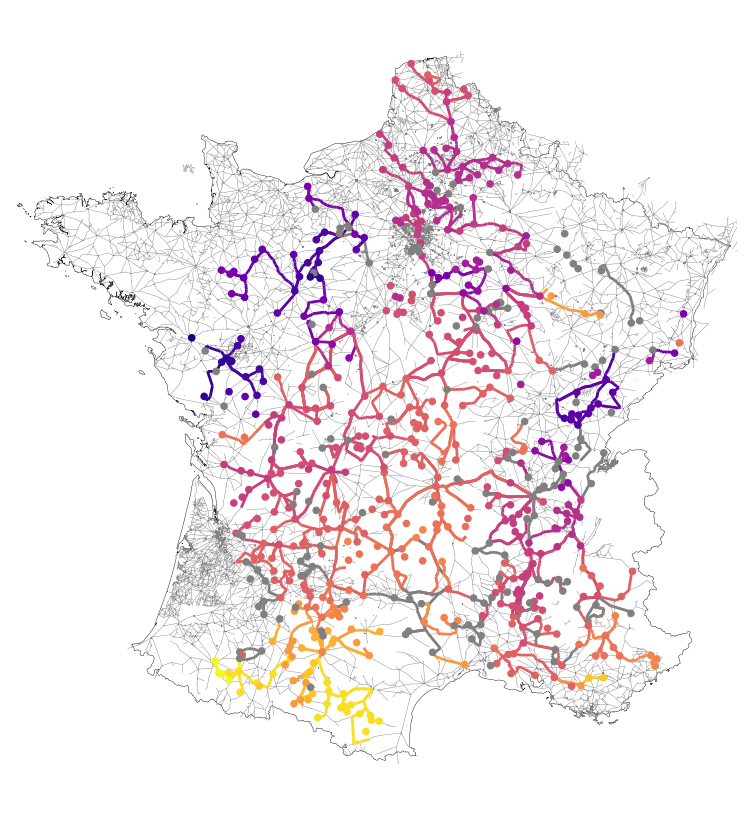

In [41]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
fr_outline.plot(ax=ax, facecolor="white", edgecolor='black', lw=0.3)
nx.draw_networkx_edges(G_roads, pos=nx.get_node_attributes(G_roads, "pos"), edge_color="grey", width=0.3)
nx.draw(G_tot, pos=nx.get_node_attributes(G_tot, "location"), with_labels=False, node_size=20, node_color=node_color, font_size=5, font_weight='bold', edge_color='white', arrows=False, width=0.1)
for index, row in df_edge.iterrows():
    source=row["source"]
    target=row["target"]
    source_id=dic_node_id.get(source)
    target_id=dic_node_id.get(target)
    dist_s=dic_dist.get(source)/1000
    dist_t=dic_dist.get(target)/1000
    
    if np.isnan(row["day"]):
        color_1="grey"
    else:
        i_col=int(row["day"])-20
        color_1=colors3[i_col]
    hex_color =colors.to_hex(color_1)
    shortest_path=nx.shortest_path(G_roads, source=source_id, target=target_id, weight="length")
#        nodes.plot(ax=ax, edgecolor="grey")
    path_edges = list(zip(shortest_path, shortest_path[1:]))
    nx.draw_networkx_edges(G_roads, pos=nx.get_node_attributes(G_roads, "pos"), edgelist=path_edges, edge_color=hex_color, width=2)
plt.xlim(0.32e7,0.42e7)
plt.ylim(2.1e6,3.2e6)  
#plt.savefig("map_tot_colors.pdf")
plt.show()

#nx.draw(G_tot, pos=nx.get_node_attributes(G_tot, "location"), with_labels=False, node_size=20, node_color=node_color, font_weight='bold', edge_color='white', arrows=False, width=0)




#### Figure 1a

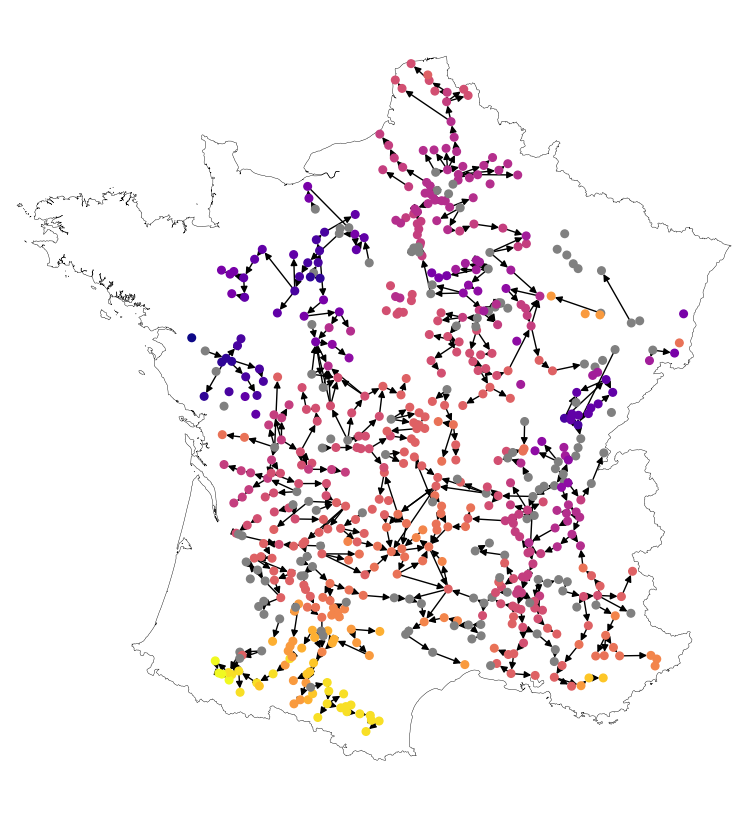

In [42]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
fr_outline.plot(ax=ax, facecolor="white", edgecolor='black', lw=0.3)
nx.draw(G_tot, pos=nx.get_node_attributes(G_tot, "location"), with_labels=False, node_size=30, node_color=node_color, font_size=5, font_weight='bold', edge_color='black', arrows=True, width=1)
plt.xlim(0.32e7,0.42e7)
plt.ylim(2.1e6,3.2e6)  
#plt.savefig("arrows_2.pdf")
plt.show()


#### Velocity distribution (euclidean distance)

In [43]:
list_v=[]
for u, v in G_tot.edges():
    velocity=G_tot[u][v]['velocity']
    if(pd.notna(velocity)):
        list_v.append(velocity)

Text(0.5, 0, '$v$ (km/day)')

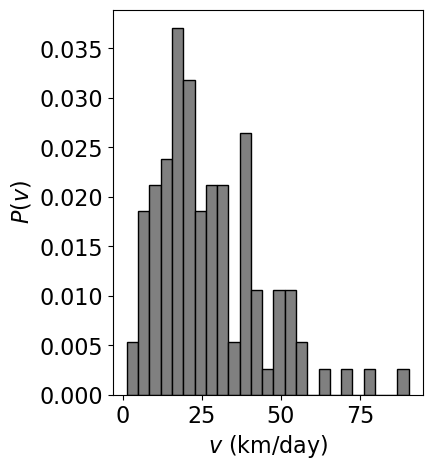

In [44]:
fig = plt.figure(figsize=(4,5))
plt.hist(list_v, bins=25, color="grey", edgecolor="black", density=True)
#plt.plot(bins[:-1],counts, ls="dashed", color="black")
plt.ylabel(r"$P(v)$")
plt.xlabel(r"$v$ (km/day)")
#plt.yscale("log")
#plt.legend()

In [45]:
df_edge["road_velocity"]=df_edge["road_distance"]/df_edge["travel_time"]

In [46]:
list_v2=df_edge.road_velocity.dropna()

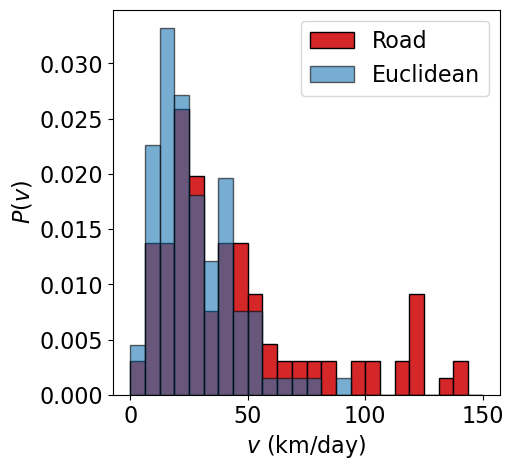

In [47]:
fig = plt.figure(figsize=(5,5))
plt.hist(list_v2, bins=np.linspace(0, 150, 25), color="tab:red", edgecolor="black", density=True, alpha=1, label="Road")
plt.hist(list_v, bins=np.linspace(0, 150, 25), color="tab:blue", edgecolor="black", density=True, alpha=0.6, label="Euclidean")
#plt.plot(bins[:-1],counts, ls="dashed", color="black")
plt.ylabel(r"$P(v)$")
plt.xlabel(r"$v$ (km/day)")
#plt.yscale("log")
plt.legend()

##### Connected components (Fig. 1b)

In [48]:
# Find weakly connected components
components = list(nx.weakly_connected_components(G_tot))

# Generate distinct colors for each component
colors2 = list(colors.XKCD_COLORS.keys())  # Use Tableau colors for variety
random.shuffle(colors2)
color_map = {}
for i, component in enumerate(components):
        for node in component:
            if len(component)>4:
                color_map[node] = colors2[i % len(colors2)]  # Cycle colors if components > len(colors)
            else:
              color_map[node] = "gray"  

# Assign gray to disconnected nodes
#for node in nodes:
#    if node not in color_map:
#        color_map[node] = "gray"


In [49]:
node_colors = [color_map[node] for node in G_tot.nodes()]

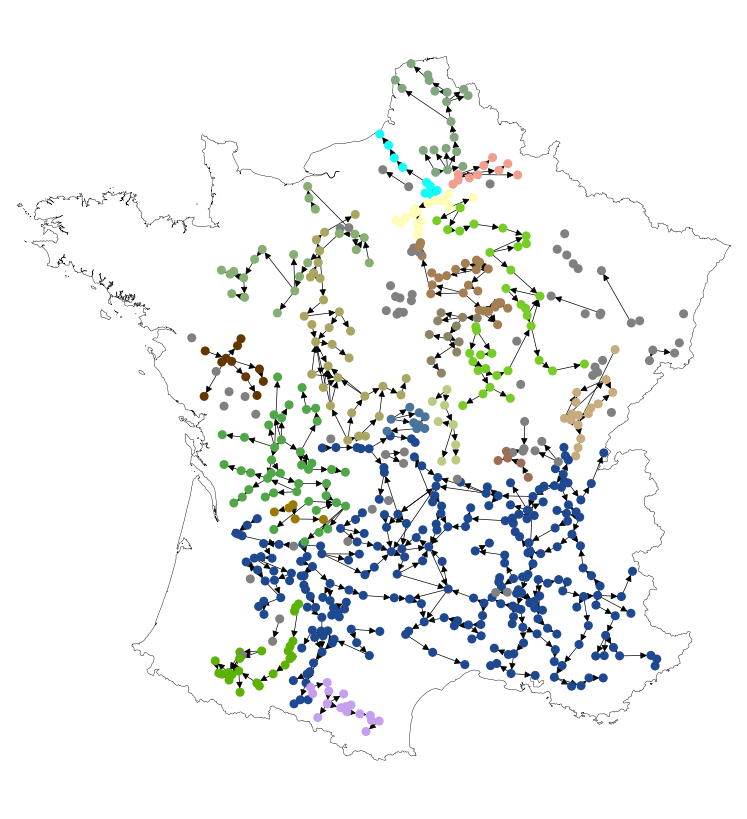

In [50]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
fr_outline.plot(ax=ax, facecolor="white", edgecolor='black', lw=0.3)
#nx.draw_networkx_edges(G_roads, pos=nx.get_node_attributes(G_roads, "pos"), edge_color="grey", width=0.3)
nx.draw(G_tot, pos=nx.get_node_attributes(G_tot, "location"), node_color=node_colors, with_labels=False, node_size=30, font_weight='bold', edge_color='black', arrows=True, width=0.5)
plt.xlim(0.32e7,0.42e7)
plt.ylim(2.1e6,3.2e6)  
#plt.savefig("map_clustes_arrow.pdf")
plt.show()


#### Epidemic activity

In [51]:
time_list=df_node.Day.dropna().unique()

In [52]:
time_list=np.sort(time_list)

In [53]:
df_degree=pd.DataFrame(columns=["time","R0","av_k"])
for time in time_list:
    filtered_nodes = [n for n, attr in G_tot.nodes(data=True) if attr.get("Day") == time]
    k = [G_tot.nodes[n]["degree"] for n in filtered_nodes]
    av_k=np.mean(k)
    av_k2=np.mean(np.array(k)**2)
    R0=av_k2/av_k-1
    df_0=pd.DataFrame({"time":[time-20],"R0":[R0],"av_k":[av_k]})
    df_degree=pd.concat([df_degree,df_0])
#    print(time,R0,av_k)

/var/folders/jy/mpqy4_yn7k50zgjy8wz8th6r0000gp/T/ipykernel_54607/61706673.py:7: RuntimeWarning: invalid value encountered in scalar divide
  R0=av_k2/av_k-1


In [54]:
df_degree=df_degree.dropna().reset_index()

Text(0.5, 0, 'Days from July 20, 1789')

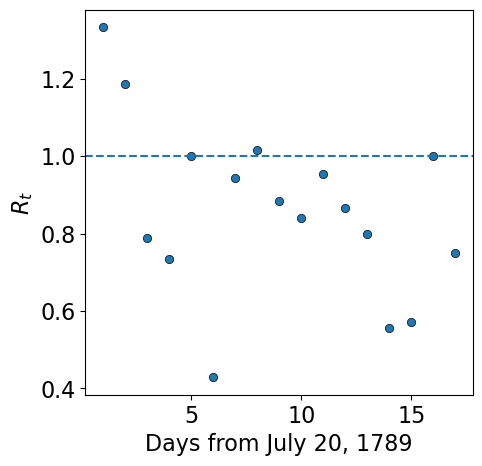

In [55]:
#sns.lineplot(data=df_degree, x="time", y="R0")
fig = plt.figure(figsize=(5,5))
sns.scatterplot(data=df_degree, x="time", y="av_k", edgecolor="black")
plt.axhline(y=1, ls="dashed")
plt.ylabel(r"$R_t$")
plt.xlabel("Days from July 20, 1789")

#### Comparison with the SIR model

In [56]:
def deriv(y, t, N, beta, gamma):
# definition of the derivatives in the SIR model
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [57]:
def sir_simul(t_max,N,beta,gamma):
# simulation of the SIR model
    t = np.linspace(0, t_max, t_max)
    I0, R0 = 1, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    y0 = S0, I0, R0
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return t,S,I,R



In [58]:
# Initial guess of parameters
gamma=0.8
beta=1.4
N=496
initial_guess=[gamma, beta, 500] 

In [61]:
activity=df_node.groupby("Day").count().reset_index()[["Day","name"]]
activity.Day=activity.Day-20

In [62]:
data_series1=activity.name.to_numpy()

In [63]:
data_series2=np.cumsum(data_series1)

In [65]:
def objective(params):
# Objective function for the fit
    gamma, beta, N = params
    t_max=18
    t, S, I, R=sir_simul(t_max,N,beta,gamma)
    simulated_values = I+R
    # Calculate the mean squared error between data_series and simulated_values
    mse = np.mean((data_series2 - simulated_values) ** 2)
    return mse

In [66]:
# Perform the optimization
result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=[(0,10),(0,10),(0,10000)])


In [67]:
gamma=result.x[0]
beta=result.x[1]
N=result.x[2]

In [68]:
print(beta,gamma,N)

1.753538380128965 1.1668843132882107 854.180199492037


In [69]:
t_max=18
t,S, I, R=sir_simul(t_max,N,beta,gamma)

In [70]:
x=activity.Day
y=activity["name"].cumsum()

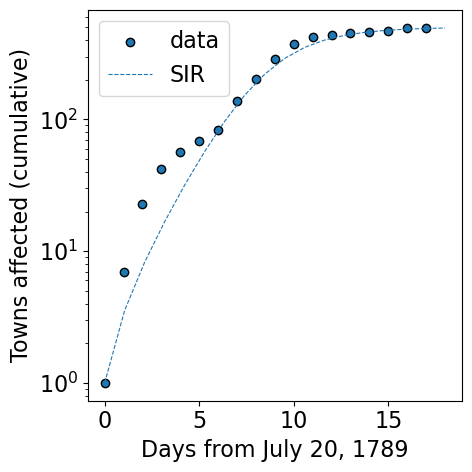

In [71]:
fig = plt.figure(figsize=(5,5))
plt.scatter(x,y, edgecolor="black", label="data")
plt.plot(t,R+I, color="tab:blue", ls="dashed", lw=0.8, label="SIR")
#plt.plot(x[2:11], aa*2**(bb*x[2:11]), linestyle='dashed', color="tab:blue", lw=0.8, label=r"$C*2^{t/\tau_D}$ $\tau_D=49$h")
plt.yscale("log")
plt.legend()
plt.ylabel("Towns affected (cumulative)")
plt.xlabel("Days from July 20, 1789")
plt.tight_layout()
#plt.savefig("cumul.pdf")


In [72]:
diff=np.gradient(I+R)

Text(0.5, 0, 'Days from July 20, 1789')

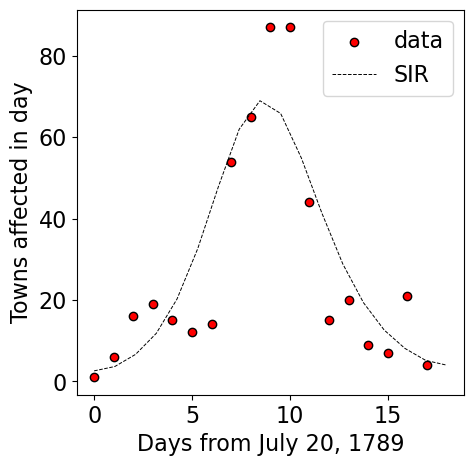

In [73]:
fig = plt.figure(figsize=(5,5))
plt.scatter(x,data_series1, edgecolor="black", color="red", label="data")
plt.plot(t,diff,color="black",  ls="dashed", lw=0.7, label="SIR")
plt.legend()
plt.ylabel("Towns affected in day")
plt.xlabel("Days from July 20, 1789")